## Задача

Продолжение разведывательного анализа реальных данных для использования их в экспериментах
с многорукиим бандитами.

Продолжается поиск и исследование пользователей, события которых можно задействовать для перехода
к табличному определнию задачи многоруких бандитов.

### Новые вводные

Основные результаты и выводы предыдущих исследований:

1. Не редки ситуации, когда у пользователя большинство событий принадлежат одной категории.
2. Не редки ситуации, когда у пользователя все события умещаются в интервал в несколько часов.
3. Не редки ситуации, когда у пользователя все события сосредоточены вокруг нескольких моментов времени. Можно сказать, что у пользователей мало сессий.

    
### Цели и гипотезы текущего исследования

В рамках настоящего исследования осуществляется поиск пользователей, для которых не наблюдается первый из перечисленных выше признаков. То есть пользователи, у которых большинство событий принадлежат как минимум двум категориям.

Попытаться найти пользователей, у которых:

События принадлежат к нескольким категориям, нет одной доминирующей категории. Это называется внутренним разнообразием категорий. Требование низкого разнообразия категорий (отношения числа категорий к числу событий) сохраняется.


## Метод исследования

- Формализовать понятие внутреннего разнообразия категорий
- Найти пользователей, у которых нет одной доминирующей категории (вывести критерий отбора)
- Оценить число таких пользователей и проанализировать визуально логи событий для выбранных случайно пользователей.


In [1]:
import glob

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

DATA_PATH = '../../data/cosmetics_ecommerce_events'
RESULTS_PATH = '../../results/cosmetics_ecommerce_events/exploratory_users_category_events_inner_diversity'

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" #last_expr

## Загрузка данных и расчет уже известных статистик

In [2]:
df = pd.read_csv(f'{DATA_PATH}/2019-Oct.csv')

По результатам предыдущего исследования - предлагается рассмотреть только события корзины

In [3]:
df.shape

user_events = df[['user_id', 'user_session', 'event_time', 'product_id', 'event_type', 'price', 'category_id', 'brand']]

user_events = user_events[user_events['event_type'] == 'cart']

user_events.shape

(4102283, 9)

(1232385, 8)

Расчет числа событий для каждого пользователя (только события корзины)

In [4]:
# events counts
events_count_per_user = user_events.groupby(['user_id'])['event_type'].count()
events_count_per_user.shape

user_stats = events_count_per_user.to_frame().rename(columns={'event_type': 'events_count'})

user_stats['log10_events_count'] = np.log10(user_stats['events_count'])

(133818,)

Расчет разнообразия категорий по событиям корзины.

In [5]:
user_category_stat = user_events.groupby(['user_id'])['category_id'].agg(['nunique', 'count'])
user_category_stat['category_diversity'] = user_category_stat['nunique'] / user_category_stat['count']
user_category_stat = user_category_stat.rename(columns={'nunique': 'category_nunique', 'count': 'category_count'})
user_category_stat = user_category_stat.drop(columns=['category_count'])
user_category_stat.shape

user_stats = user_stats.merge(user_category_stat, how='inner', left_index=True, right_index=True)
user_stats.shape

user_stats[~user_stats['category_diversity'].isna()]

(133818, 2)

(133818, 4)

events_count  log10_events_count  category_nunique  \
user_id                                                         
4103071               1            0.000000                 1   
8846226              24            1.380211                15   
9794320              13            1.113943                 1   
10280338             26            1.414973                 6   
10968431              1            0.000000                 1   
...                 ...                 ...               ...   
566272734             7            0.845098                 2   
566274213             2            0.301030                 1   
566274454             3            0.477121                 1   
566274533             1            0.000000                 1   
566280278             2            0.301030                 1   

           category_diversity  
user_id                        
4103071              1.000000  
8846226              0.625000  
9794320              0.076923  
10280338             0.230769  
10968431             1.000000  
...                       ...  
566272734            0.285714  
566274213            0.500000  
566274454            0.333333  
566274533            1.000000  
566280278            0.500000  

[133818 rows x 4 columns]

## Формализация и расчет внутреннего разнообразия

Интуитивно разнообразие - это присутствие в популяции большого числа различных видов или типов.

Существуют различные способы расчета внутреннего разнообразия (см., например, индексы разнообразия https://en.wikipedia.org/wiki/Diversity_index).

Одна из мер разнообразия - Индекс Джини (или Джини-Симпсона), модификация которого используется в машинном обучении, в частности, как один из критериев информативности при построении решающих деревьев.

Пусть $p_i$ - это доля объектов класса $i$ в выборке. Тогда Индекс Джини, как мера разнообразия, рассчитывается по формуле:

$$ Gini = 1 - \sum_i p_i^2 $$

### Внутреннее разнообразие событий одного пользователя

Если считать события одного пользователя популяцией, а категории - классами, то Индекс Джини можно использовать для оценки меры внутреннего разнообразия.

При доминировании одной категории в событиях пользователя Индекс Джини будет приближаться к 0. При большом числе категорий, представленных большим числом событий (сравнимом друг с другом), Индекс Джини будет приближаться к 0.

**Рассчитаем Индекс Джини как меру внутреннего разнообразия**

In [6]:
user_category_stat = user_events.groupby(['user_id', 'category_id'])['category_id'].agg(['count'])
user_category_stat = user_category_stat.reset_index(level='category_id')

user_stats_comp = user_stats.merge(user_category_stat, how='inner', left_index=True, right_index=True)
user_stats_comp['user_category_rel_square'] = np.square(user_stats_comp['count'] / user_stats_comp['events_count'])

user_stats_comp.shape

inner_category_diversity = 1 - user_stats_comp.groupby(['user_id'])['user_category_rel_square'].sum()
inner_category_diversity = inner_category_diversity.to_frame().rename(columns={'user_category_rel_square': 'inner_category_diversity'})

user_stats = user_stats.merge(inner_category_diversity, how='inner', left_index=True, right_index=True)
user_stats.shape
user_stats
# user_stats[~user_stats['category_diversity'].isna()]


(419498, 7)

(133818, 5)

events_count  log10_events_count  category_nunique  \
user_id                                                         
4103071               1            0.000000                 1   
8846226              24            1.380211                15   
9794320              13            1.113943                 1   
10280338             26            1.414973                 6   
10968431              1            0.000000                 1   
...                 ...                 ...               ...   
566272734             7            0.845098                 2   
566274213             2            0.301030                 1   
566274454             3            0.477121                 1   
566274533             1            0.000000                 1   
566280278             2            0.301030                 1   

           category_diversity  inner_category_diversity  
user_id                                                  
4103071              1.000000                  0.000000  
8846226              0.625000                  0.909722  
9794320              0.076923                  0.000000  
10280338             0.230769                  0.585799  
10968431             1.000000                  0.000000  
...                       ...                       ...  
566272734            0.285714                  0.244898  
566274213            0.500000                  0.000000  
566274454            0.333333                  0.000000  
566274533            1.000000                  0.000000  
566280278            0.500000                  0.000000  

[133818 rows x 5 columns]

In [7]:
from IPython.core.interactiveshell import InteractiveShell
current_ast_node_interactivity = InteractiveShell.ast_node_interactivity
InteractiveShell.ast_node_interactivity = "last_expr"

**Визуализируем основные статистики: число событий, разнообразие категорий, внутреннее разнообразие категорий**

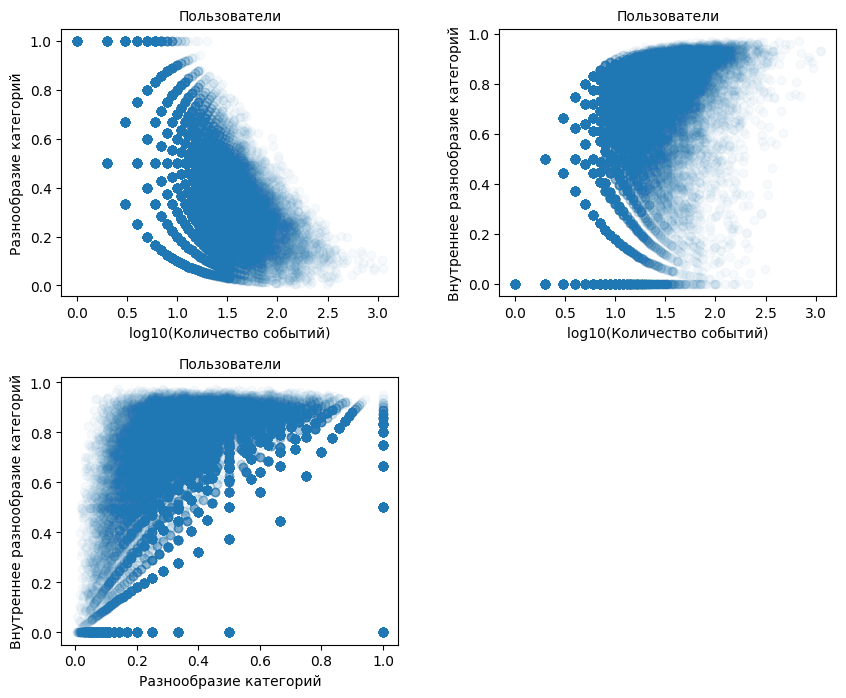

In [8]:
fig = plt.figure(figsize=(10,8))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.subplot(221)
plt.xlabel('log10(Количество событий)')
plt.ylabel('Разнообразие категорий')
plt.title('Пользователи', size=10)
plt.scatter(user_stats['log10_events_count'], user_stats['category_diversity'], alpha=0.03)

plt.subplot(222)
plt.xlabel('log10(Количество событий)')
plt.ylabel('Внутреннее разнообразие категорий')
plt.title('Пользователи', size=10)
plt.scatter(user_stats['log10_events_count'], user_stats['inner_category_diversity'], alpha=0.03)

plt.subplot(223)
plt.xlabel('Разнообразие категорий')
plt.ylabel('Внутреннее разнообразие категорий')
plt.title('Пользователи', size=10)
plt.scatter(user_stats['category_diversity'], user_stats['inner_category_diversity'], alpha=0.03)

Можно отметить:
- существуют пользователи во всем интервале значений внутреннего разнообразия
- пользователей с большим внутренним разнообразием больше с малым разнообразием категорий, что удобно, поскольку именно пользователи с малым разнообразием категорий рассматриваются
- кажется, что большое внутреннее разнообразие слабо зависит от общего числа событий пользователя

In [10]:
InteractiveShell.ast_node_interactivity = current_ast_node_interactivity

## Выбор и исследование пользователей по критерию внутреннего разнообразия

**Отберем пользователей с различными значенияим внутреннего разнообразия**

In [12]:
predicate = (user_stats['category_diversity'] < 0.1)\
  & (user_stats['events_count'] > 100)\
  & (user_stats['inner_category_diversity'] > 0.75)
len(user_stats[predicate])

39

Оказалось, что есть всего 39 пользователей с числом событий больше 100, разнообразием категорий < 0.1 и внутренним разнообразием больше 0.75.

С другой стороны, большое внутреннее разнообразие может свидетельствовать о том, что почти все категории хорошо представлены в событиях пользователя. На практике, вероятно, интерес могут представлять пользователи с наличием "шумовых" категорий, наряду с основными.

Отберем пользователей с внутренним разнообразием в диапазоне [0.5; 0.6].

In [14]:
# можно ли найти пользователя с большим числом событий и низким разнообразием

predicate = (user_stats['category_diversity'] < 0.1)\
  & (user_stats['events_count'] > 100)\
  & (user_stats['inner_category_diversity'] > 0.5)\
  & (user_stats['inner_category_diversity'] < 0.6)
len(user_stats[predicate])

selected = user_stats[predicate]

pd.set_option('display.max_rows', len(selected))
selected
pd.reset_option('display.max_rows')

21

events_count  log10_events_count  category_nunique  \
user_id                                                         
265366822           145            2.161368                12   
321298686           138            2.139879                 9   
324101257           141            2.149219                 5   
433401909           175            2.243038                16   
467092698           104            2.017033                 5   
472137016           115            2.060698                10   
493366979           154            2.187521                 6   
495473583           193            2.285557                 4   
500966576           101            2.004321                 8   
510785518           406            2.608526                12   
511149216           103            2.012837                 5   
511871925           118            2.071882                 7   
538580192           291            2.463893                19   
549158482           302            2.480007                11   
552908674           362            2.558709                16   
553861723           187            2.271842                12   
555267314           111            2.045323                 9   
555998877           292            2.465383                26   
557316433           122            2.086360                 7   
558186841           157            2.195900                 5   
558397496           137            2.136721                 9   

           category_diversity  inner_category_diversity  
user_id                                                  
265366822            0.082759                  0.506825  
321298686            0.065217                  0.551670  
324101257            0.035461                  0.554197  
433401909            0.091429                  0.566204  
467092698            0.048077                  0.521635  
472137016            0.086957                  0.558639  
493366979            0.038961                  0.537527  
495473583            0.020725                  0.514430  
500966576            0.079208                  0.546417  
510785518            0.029557                  0.562511  
511149216            0.048544                  0.551042  
511871925            0.059322                  0.566935  
538580192            0.065292                  0.572879  
549158482            0.036424                  0.554449  
552908674            0.044199                  0.574570  
553861723            0.064171                  0.540136  
555267314            0.081081                  0.541028  
555998877            0.089041                  0.594976  
557316433            0.057377                  0.575114  
558186841            0.031847                  0.586555  
558397496            0.065693                  0.536416

Таких пользователей всего 21.

Можно вручную просмотреть события одного из отобранных пользователей

In [15]:
user_id = 500966576

In [17]:
np.random.seed(1)

selected_user_events = user_events[user_events['user_id'] == user_id]

selected_user_events.shape

selected_user_events['event_time'] = pd.to_datetime(selected_user_events['event_time'])

selected_user_events = selected_user_events.sort_values(by=['event_time'], kind='mergesort')

selected_user_events['time_delta'] = selected_user_events['event_time'] - selected_user_events.iloc[0]['event_time']
selected_user_events['time_delta_sec'] = selected_user_events['time_delta'].apply(lambda x: x.total_seconds())

#pd.set_option('display.max_rows', len(selected_user_events))
selected_user_events
#pd.reset_option('display.max_rows')

(101, 8)

/home/Valentin/mldev-recommender-systems-experiment/venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


user_id                          user_session  \
464683  500966576  f1f2e2ec-6a18-4777-8479-acfd8faf7c32   
464754  500966576  f1f2e2ec-6a18-4777-8479-acfd8faf7c32   
464771  500966576  f1f2e2ec-6a18-4777-8479-acfd8faf7c32   
464893  500966576  f1f2e2ec-6a18-4777-8479-acfd8faf7c32   
464980  500966576  f1f2e2ec-6a18-4777-8479-acfd8faf7c32   
...           ...                                   ...   
466629  500966576  4552af6c-b9a9-4b51-9d63-d36b6bf095c8   
466630  500966576  4552af6c-b9a9-4b51-9d63-d36b6bf095c8   
466632  500966576  4552af6c-b9a9-4b51-9d63-d36b6bf095c8   
466635  500966576  4552af6c-b9a9-4b51-9d63-d36b6bf095c8   
466636  500966576  4552af6c-b9a9-4b51-9d63-d36b6bf095c8   

                      event_time  product_id event_type  price  \
464683 2019-10-03 21:58:44+00:00     5666627       cart  10.32   
464754 2019-10-03 22:00:28+00:00     5730214       cart   8.25   
464771 2019-10-03 22:00:51+00:00     5751422       cart  10.95   
464893 2019-10-03 22:03:32+00:00     5780720       cart   5.56   
464980 2019-10-03 22:04:48+00:00     5814046       cart   6.27   
...                          ...         ...        ...    ...   
466629 2019-10-03 22:49:03+00:00     5565820       cart   0.40   
466630 2019-10-03 22:49:04+00:00     5565820       cart   0.40   
466632 2019-10-03 22:49:05+00:00     5565820       cart   0.40   
466635 2019-10-03 22:49:06+00:00     5565820       cart   0.40   
466636 2019-10-03 22:49:08+00:00     5565820       cart   0.40   

                category_id    brand      time_delta  time_delta_sec  
464683  1487580005268456287      NaN 0 days 00:00:00             0.0  
464754  1487580005268456287      NaN 0 days 00:01:44           104.0  
464771  1487580005268456287      uno 0 days 00:02:07           127.0  
464893  1487580005092295511     pole 0 days 00:04:48           288.0  
464980  1487580005092295511  grattol 0 days 00:06:04           364.0  
...                     ...      ...             ...             ...  
466629  1487580009311764506      NaN 0 days 00:50:19          3019.0  
466630  1487580009311764506      NaN 0 days 00:50:20          3020.0  
466632  1487580009311764506      NaN 0 days 00:50:21          3021.0  
466635  1487580009311764506      NaN 0 days 00:50:22          3022.0  
466636  1487580009311764506      NaN 0 days 00:50:24          3024.0  

[101 rows x 10 columns]

Можно также визуализировать восстановленную плотность событий выбранного пользователя

In [19]:
from IPython.core.interactiveshell import InteractiveShell
current_ast_node_interactivity = InteractiveShell.ast_node_interactivity
InteractiveShell.ast_node_interactivity = "last_expr"

15.12


Text(0.5, 1.0, 'Восстановленная плотность событий корзины пользователя 500966576')

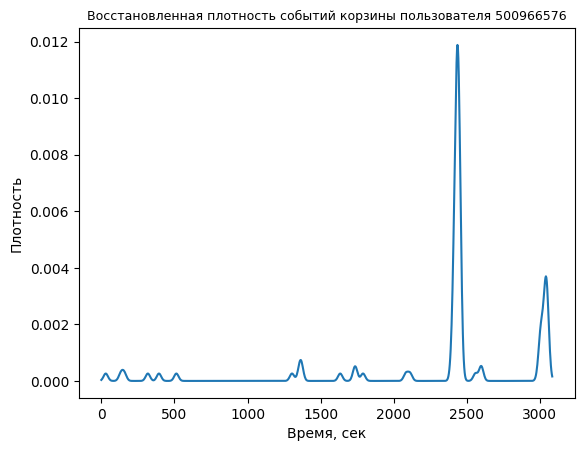

In [20]:
from sklearn.neighbors import KernelDensity

np.random.seed(1)

x = selected_user_events[['time_delta_sec']]

bwdth = x['time_delta_sec'].max() / 200
print(bwdth)
x = x + 2 * bwdth

kde = KernelDensity(kernel='gaussian', bandwidth=bwdth).fit(x)

space = np.linspace(0, max(x['time_delta_sec']) + 2 * bwdth, 1000).reshape(-1, 1)
log_density = kde.score_samples(space)

plt.plot(space, np.exp(log_density))
plt.xlabel('Время, сек')
plt.ylabel('Плотность')
plt.title(f'Восстановленная плотность событий корзины пользователя {user_id}', size=9)


In [21]:
InteractiveShell.ast_node_interactivity = current_ast_node_interactivity

In [22]:
one_user_events = user_events[user_events['user_id'] == user_id]
one_user_events = one_user_events[['event_time', 'category_id']]
one_user_events['event_time'] = pd.to_datetime(one_user_events['event_time'])

one_user_events.shape

#pd.set_option('display.max_rows', len(one_user_events))
one_user_events = one_user_events.sort_values(by=['event_time'])
one_user_events
#pd.reset_option('display.max_rows')

(101, 2)

event_time          category_id
464683 2019-10-03 21:58:44+00:00  1487580005268456287
464754 2019-10-03 22:00:28+00:00  1487580005268456287
464771 2019-10-03 22:00:51+00:00  1487580005268456287
464893 2019-10-03 22:03:32+00:00  1487580005092295511
464980 2019-10-03 22:04:48+00:00  1487580005092295511
...                          ...                  ...
466629 2019-10-03 22:49:03+00:00  1487580009311764506
466630 2019-10-03 22:49:04+00:00  1487580009311764506
466632 2019-10-03 22:49:05+00:00  1487580009311764506
466635 2019-10-03 22:49:06+00:00  1487580009311764506
466636 2019-10-03 22:49:08+00:00  1487580009311764506

[101 rows x 2 columns]

In [23]:
from IPython.core.interactiveshell import InteractiveShell
current_ast_node_interactivity = InteractiveShell.ast_node_interactivity
InteractiveShell.ast_node_interactivity = "last_expr"

Наконец, визуализируем лог событий пользователя по категориям

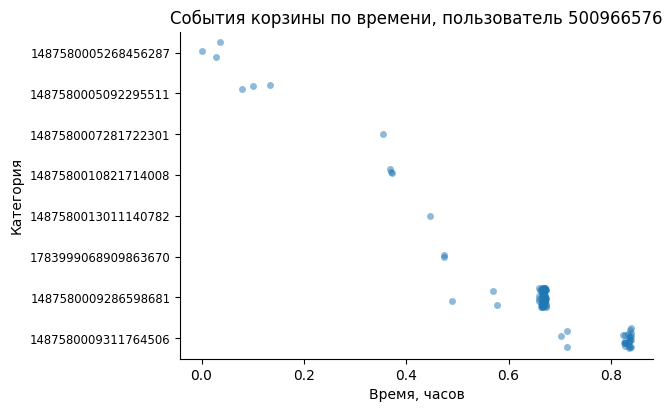

In [24]:
user_id = 500966576

def plot_user_events(user_id, savefig=False, suffix=None):
    one_user_events = user_events[user_events['user_id'] == user_id]
    one_user_events = one_user_events[['event_time', 'category_id']]
    one_user_events['event_time'] = pd.to_datetime(one_user_events['event_time'])

    one_user_events['time_delta'] = one_user_events['event_time'] - one_user_events.iloc[0]['event_time']
    one_user_events['time_delta_sec'] = one_user_events['time_delta'].apply(lambda x: x.total_seconds())
    one_user_events['time_delta_hrs'] = one_user_events['time_delta'].apply(lambda x: x.total_seconds()/(60 * 60))
    one_user_events['category_id_str'] = one_user_events['category_id'].apply(lambda x: str(x))

    total_events = one_user_events.shape[0]
    max_events_count = 150 if total_events > 150 else total_events
    select_events_count = int(total_events * 0.3) if total_events * 0.3 > max_events_count else max_events_count
    #one_user_events = one_user_events.iloc[np.random.choice(total_events, select_events_count, replace=False)]

    #ax = sns.swarmplot(data=one_user_events, x="time_delta_sec", y="category_id_str", size=3)
    select_events_count = total_events
    #plt.figure(figsize=(15,15))
    fig = plt.figure()
    ax = sns.catplot(data=one_user_events, x="time_delta_hrs", y="category_id_str", jitter=0.25, height=4, aspect=7/4)
    plt.setp(ax.ax.collections, alpha=.5)
    ax.ax.set_title(f'События корзины по времени, пользователь {user_id}')
    ax.ax.set_xlabel('Время, часов')
    ax.ax.tick_params(axis='y', which='major', labelsize='small')
    ax.ax.set_ylabel('Категория')

    if savefig:
        if suffix:
            plt.savefig(f'{RESULTS_PATH}/{suffix}/user_{user_id}_category_events.png', dpi=300)
        else:
            plt.savefig(f'{RESULTS_PATH}/user_{user_id}_category_events.png', dpi=300)        
    plt.close(fig)
        
plot_user_events(user_id)

plt.ion()

Можно отметить, что у пользователя две преобладающие категории (основные интересы) и много других категорий ("шумовые" интересы). Именно это и ожидалось при формулированных критериях.

**Визуализируем логи событий по категориям нескольких случайно выбранных пользователей среди отобранных**

In [ ]:
#plt.ioff()

user_ids = [472137016, 493366979, 500966576, 510785518, 511149216, 511871925, 538580192, \
            549158482, 552908674, 555998877]

for user_id in user_ids:
    #plot_user_events(user_id, True, 'inner_div_lt_06_gt_05')
    plot_user_events(user_id)

#plt.close('all')
#plt.ion()

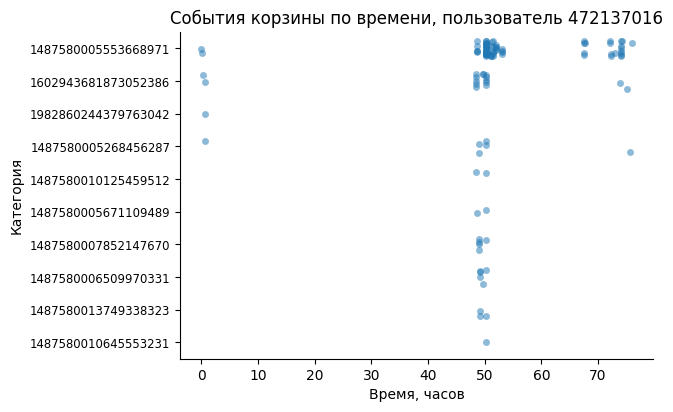

In [28]:
plot_user_events(472137016)

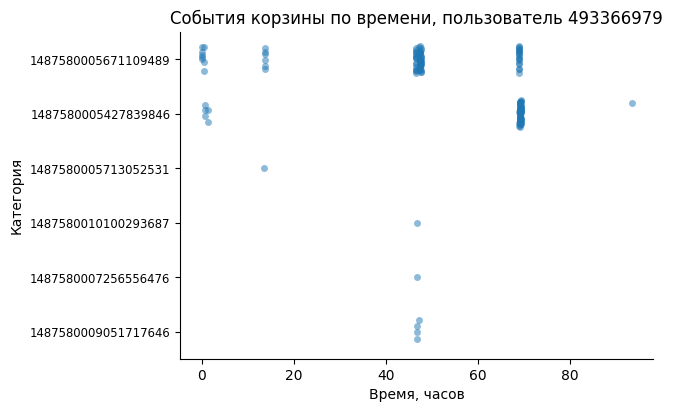

In [29]:
plot_user_events(493366979)

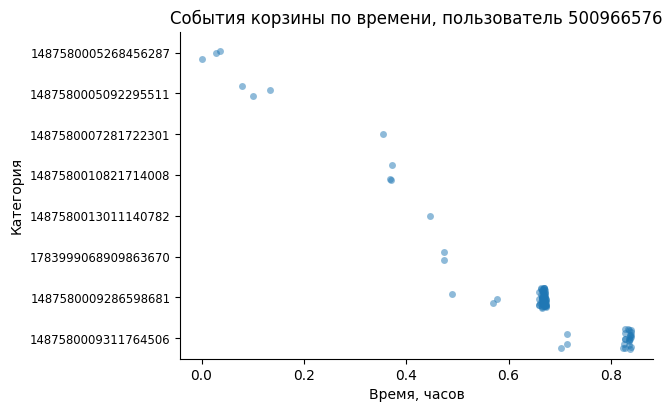

In [30]:
plot_user_events(500966576)

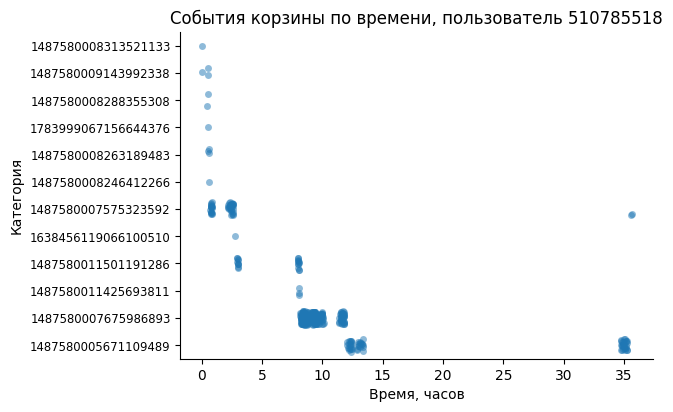

In [31]:
plot_user_events(510785518)

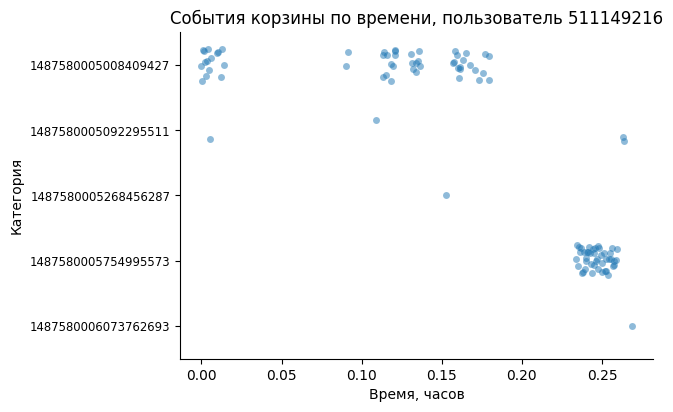

In [32]:
plot_user_events(511149216)

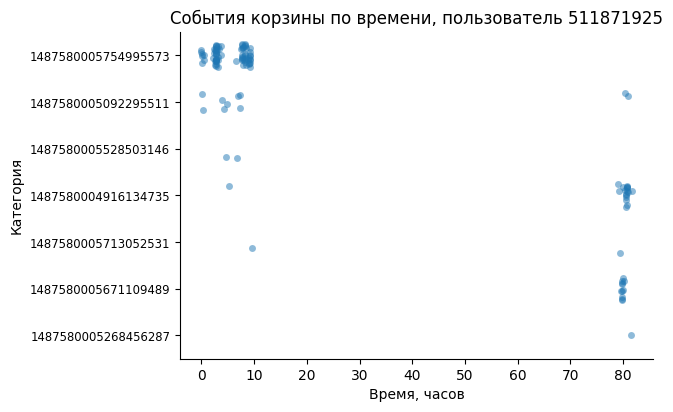

In [33]:
plot_user_events(511871925)

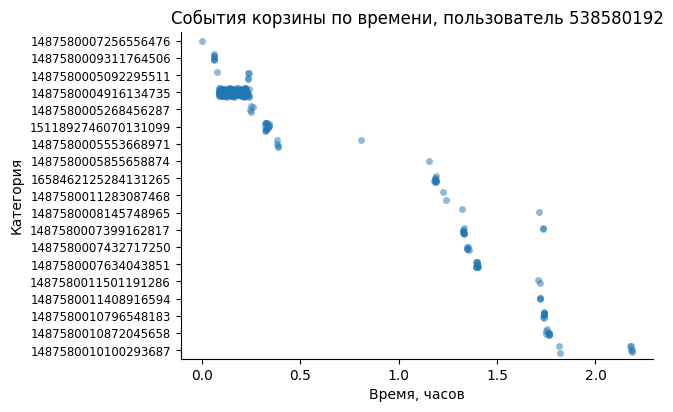

In [34]:
plot_user_events(538580192)

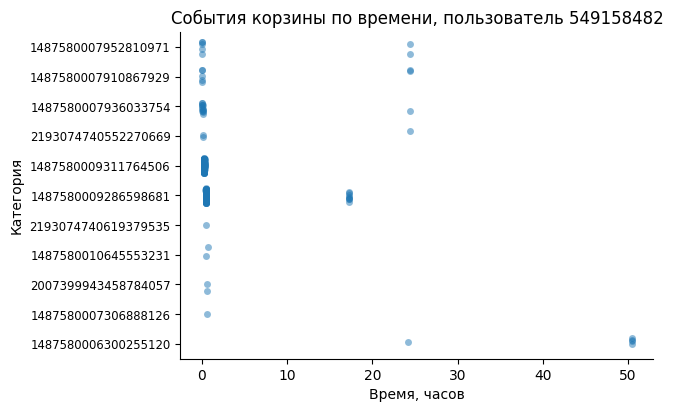

In [35]:
plot_user_events(549158482)

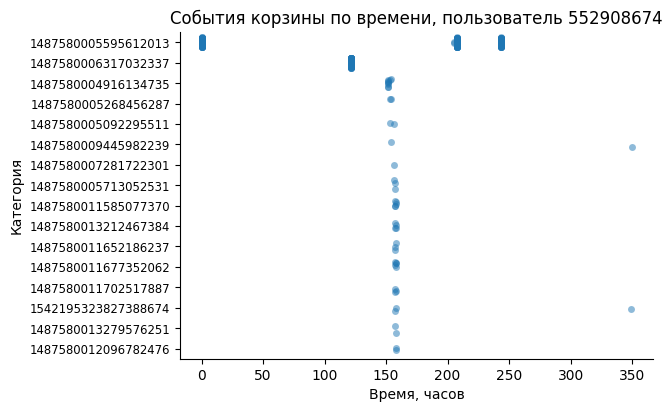

In [36]:
plot_user_events(552908674)

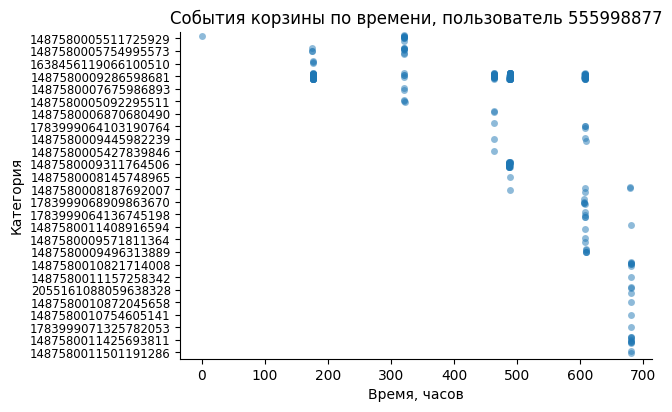

In [37]:
plot_user_events(555998877)

Можно заключить, что ситуация, где в событиях пользователя доминирует лишь одна категория исключена. Более того, введенный критерий позволяет находить пользователей, у которых есть как существенно представленные, так и слабо представленные категории.

Однако, по-прежнему наблюдаются ситуации, когда вся активность пользователя умещается в несколько часов, а также сосредоточение почти всех событий вокруг неболього числа моментов времени (сессий). Можно отметить, что при малом числе сессий зачастую каждая сессия вмещает в себя события одной категории, что, как кажется, не очень удобно для исследований.

## Выводы

Понятие внутреннего разнообразия категорий удалось формализовать через Индекс Джини. 
Это позволило найти пользователей, у которых нет одной доминирующей категории.
Более того, введенный критерий позволяет находить пользователей с различным числом категорий, которые существенно представлены в событиях пользователя.

По-прежнему не редки ситуации, когда у пользователя все события умещаются в интервал в несколько часов, и когда у пользователя все события сосредоточены вокруг нескольких моментов времени (мало сессий).

В дальнейшем нужно найти способ формализовать сессию на основе данных, и отфильтровать пользователей по этом критерию.
